## Accessing in-situ data in OEMC STAC

The best way to access in-situ data in OEMC STAC is via [pystac library](https://pystac.readthedocs.io/en/stable/api/pystac.html). The current version is based on a static catalog (https://s3.eu-central-1.wasabisys.com/stac/oemc/catalog.json) presented in STAC Browser client (http://stac.earthmonitor.org).

Let's first create a Catalog object from the remote URL:

In [7]:
import pystac 
STAC_URL = 'https://s3.eu-central-1.wasabisys.com/stac/oemc/catalog.json'
catalog = pystac.Catalog.from_file(STAC_URL)

... and now let's harvest all asset items for a [Pandas DataFrame](https://pandas.pydata.org/): 

In [120]:
import pandas as pd 

df = []

for collection in catalog.get_collections():
    for item in collection.get_items(recursive=True):
        for key in item.assets.keys():
            if 'data' in item.assets[key].roles or 'external' in item.assets[key].roles:
                df.append({
                    'title': collection.title,
                    'description': collection.description,
                    'start_datetime': item.properties['start_datetime'],
                    'end_datetime': item.properties['end_datetime'],
                    'asset': item.assets[key].title,
                    'asset_url': item.assets[key].href,
                    'asset_type': item.assets[key].roles[0],
                    'keywords': collection.keywords
                })

df = pd.DataFrame(df)
                
df['type'] = df['asset_type'].map(lambda k:  'ARIS Data' if k == 'data' else 'Raw data')
df['region'] = df['keywords'].map(lambda k:  'Global' if 'global' in k else 'Europe' if 'europe' in k else 'Regional')
df['file_ext'] = df[df['type'] == 'ARIS Data']['asset_url'].map(lambda f: Path(f).suffix.replace('?download=1','').replace('869682?format=','').replace('.',''))

Using the DataFrame, it's possible to retrieve some summary info:

In [92]:
print(f'Number of STAC datasets registered: {len(df.title.unique())}')
print(f'Number of STAC assets registered: {len(df.asset_url.unique())}')

Number of STAC datasets registered: 13
Number of STAC assets registered: 29


... and derive plots by dataset types, spatial coverage and file format:

<Axes: >

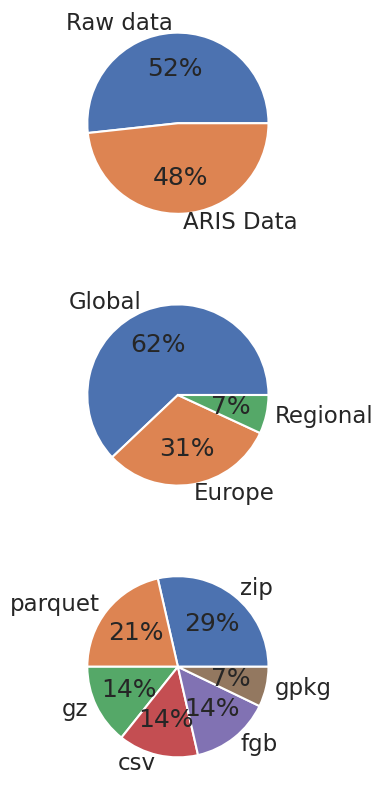

In [121]:
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

sns.set_theme(context='talk', style="whitegrid")

fig, axes = plt.subplots(3, 1,  figsize=(10, 10))

df['type'].value_counts().plot(kind='pie', y='class', ylabel='', autopct='%1.0f%%', legend=False, ax=axes[0])
df['region'].value_counts().plot(kind='pie', y='class', ylabel='', autopct='%1.0f%%', legend=False, ax=axes[1])
df['file_ext'].value_counts().plot(kind='pie', y='class', ylabel='', autopct='%1.0f%%',legend=False, ax=axes[2])

## Data reading

For Parquet files, it's possible to retrieve all column information by lazy loading using [pyarrow](https://arrow.apache.org/docs/python/index.html)

In [149]:
import pyarrow.parquet as pq
from urllib.parse import urlparse
from pyarrow import fs

for _, rows in df[df['file_ext'] == 'parquet'].iterrows(): 
    url = rows['asset_url']
    urlp = urlparse(url)
    #httpfs = fs.S3FileSystem(scheme=urlp.scheme, endpoint_override=urlp.netloc)
    #ds = pq.ParquetDataset(urlp.path[1:], filesystem=httpfs)
    print(f"Retriving column schema for {rows['title']} ")
    print(f"  URL: {url}")
    print(ds.schema)
    break


Retriving column schema for OBIS: Ocean Biogeographic Information System 
  URL: https://obis-datasets.ams3.digitaloceanspaces.com/exports/obis_20231025.parquet
id: string
dataset_id: string
decimalLongitude: float
decimalLatitude: float
date_start: int64
date_mid: int64
date_end: int64
date_year: int64
scientificName: string
originalScientificName: string
minimumDepthInMeters: float
maximumDepthInMeters: float
depth: float
coordinateUncertaintyInMeters: float
flags: string
dropped: bool
absence: bool
shoredistance: string
bathymetry: string
sst: string
sss: string
marine: bool
brackish: bool
freshwater: bool
terrestrial: bool
taxonRank: string
AphiaID: int64
redlist_category: string
superdomain: string
domain: string
kingdom: string
subkingdom: string
infrakingdom: string
phylum: string
phylum_division: string
subphylum_subdivision: string
subphylum: string
infraphylum: string
parvphylum: string
gigaclass: string
megaclass: string
superclass: string
class: string
subclass: string
infr